## 평가환경 및 장비

In [1]:
import tensorflow as tf
import numpy as np
print("HW: ")
!nvidia-smi --query-gpu=name --format=csv,noheader
print("\nOS: ")
!cat /etc/*release | grep "DESCRIPTION"
print("\nDeep learning library : ")
print(tf.__version__)
print("\nMemory : ")
!free -h 

HW: 
NVIDIA GeForce RTX 2080

OS: 
DISTRIB_DESCRIPTION="Ubuntu 20.04.4 LTS"

Deep learning library : 
2.8.0

Memory : 
              total        used        free      shared  buff/cache   available
Mem:           62Gi       2.0Gi        17Gi       4.0Mi        42Gi        60Gi
Swap:         2.0Gi        23Mi       2.0Gi


## 데이터 및 모델 불러오기

In [2]:
from utils.load_model import get_trained_model_ckpt
from utils.load_data import get_datasets, get_datasets_np
from utils.utils import set_seed

model_configs = {
  "impute": 1,
  "drop_rate": 0.4,
  "num_units": 8,
  "num_layer": 3,
  "regularize": 0.01,
  "learning_rate": 0.001,
  "label_smoothing": 0.2,
  "class_weight": 0,
  "batch_size": 128,
  "epochs": 20,
  "input_shape": [6,25]
}
model_path = 'logs/tuning_0.1'

set_seed()
model = get_trained_model_ckpt(model_path,configs=model_configs,epoch=None)
X,Y, class_weights = get_datasets_np(eval=True, drop_scores=False, tuning=True)

idx=4
X_KU_ICU = X[idx][:, :, :-5]
Y_KU_ICU = Y[idx]
model.evaluate(X_KU_ICU,Y_KU_ICU)
pred = model.predict(X_KU_ICU)
# [0.4022497534751892, 0.871715247631073, 0.14749404788017273]

2023-06-22 11:53:40.098385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 11:53:40.106186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-06-22 11:53:40.106205: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-22 11:53:40.106866: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

loading pretrained model from logs/tuning_0.1/checkpoint/run_158
Model: "severity_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 25)]           0         
                                                                 
 dropout (Dropout)           (None, 6, 25)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 16)            2176      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 6, 16)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 16)            1600      
 nal)                                                            
                                                

In [3]:
from sklearn.metrics import roc_auc_score, average_precision_score,accuracy_score

idx=4
columns = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS']
y_probs = []
total_auc = []
total_ap = []
total_acc = []


def sigmoid(lst):
    return 1 / (1 + np.exp(-np.array(lst)))


for i in range(len(columns)):
    if i == 0 : # rox index
        y_prob = 1-sigmoid(X[idx][:,-1,-5+i])
    elif i < len(columns)-1:
        y_prob = sigmoid(X[idx][:,-1,-5+i])
    else:
        y_prob = model.predict(X_KU_ICU)
    
    y_probs.append(y_prob)

    y_pred = np.where(np.array(y_prob) >= 0.5, 1, 0)

    total_auc.append(roc_auc_score(Y[idx], y_prob, average=None))
    total_ap.append(average_precision_score(Y[idx], y_prob))
    total_acc.append(accuracy_score(Y[idx], y_pred))

print(columns)
print(total_auc)
print(total_ap)
print(total_acc)

['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS']
[0.7438749779721812, 0.6761106826353639, 0.7044104825105642, 0.6945241288769614, 0.8641672547275222]
[0.04898124321215193, 0.02830344400225537, 0.03676143982334257, 0.04506927167109204, 0.14946909442534279]
[0.9889875511447723, 0.011012448855227648, 0.011012448855227648, 0.011012448855227648, 0.930769565595891]


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
fpr_list = []
tpr_list = []
auc_list = []
precision_list = []
recall_list = []
auprc_list = []

for i in range(5):
    fpr, tpr, _ = roc_curve(Y[idx], y_probs[i])
    pr, rec, _ = precision_recall_curve(Y[idx], y_probs[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc(fpr,tpr))
    precision_list.append(pr)
    recall_list.append(rec)
    auprc_list.append(auc(rec,pr))

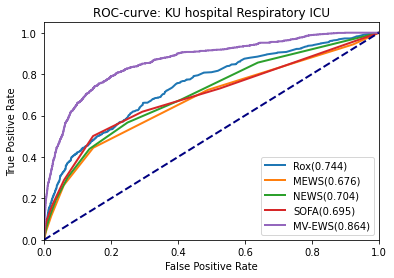

In [5]:
plt.figure()
lw = 2
label = ['Rox', 'MEWS','NEWS','SOFA','MV-EWS']
for i in range(5):
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label=label[i] + "(%0.3f)" % auc_list[i]
    )

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-curve: KU hospital Respiratory ICU")
plt.legend(loc="lower right")
plt.show()

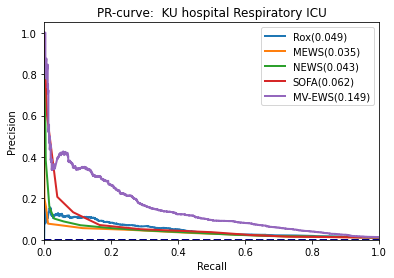

In [6]:
plt.figure()
lw = 2

for i in range(5):
    plt.plot(
        recall_list[i],
        precision_list[i],
        lw=lw,
        label=label[i] + "(%0.3f)" % auprc_list[i]
    )
plt.plot([0, 1], [0, 0], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve:  KU hospital Respiratory ICU")
plt.legend(loc="upper right")
plt.show()

In [7]:
print("Predict severity of patients using MV-EWS Model...")

data_folds = np.array_split(X_KU_ICU, 10)
label_folds = np.array_split(Y_KU_ICU, 10)
average_accuracy = 0
for i,(data,label) in enumerate(zip(data_folds,label_folds)):
    print(f"\nPredicting on {i} fold")
    prob = model.predict(data,verbose=True)
    pred=np.where(prob>0.5,1,0)
    acc = accuracy_score(label, pred)
    average_accuracy = average_accuracy + acc
    print(f"Accuracy: {acc*100:.4f}")

print(f"\nMV-EWS 모델 평균 정확도: {average_accuracy*10:.4f}")
# print("\nMV-EWS 모델 평균 정확도: %0.4f" % (average_accuracy/10)*100)


Predict severity of patients using MV-EWS Model...

Predicting on 0 fold
  1/288 [..............................] - ETA: 3s

288/288 [==============================] - 0s 2ms/step
Accuracy: 93.3950

Predicting on 1 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 93.1012

Predicting on 2 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 93.1991

Predicting on 3 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 93.0033

Predicting on 4 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 92.7639

Predicting on 5 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 93.4168

Predicting on 6 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 93.1331

Predicting on 7 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 92.6107

Predicting on 8 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 92.9590

Predicting on 9 fold
288/288 [==============================] - 0s 2ms/step
Accuracy: 93.1875

MV-EWS 모델 평균 정확도: 93.0770


In [8]:

X_KU_ICU = X[idx][:, :, :-5]
Y_KU_ICU = Y[idx]
model.evaluate(X_KU_ICU,Y_KU_ICU)
pred = model.predict(X_KU_ICU)
total_acc.append(accuracy_score(Y[idx], y_pred))

2872/2872 [==============================] - 5s 2ms/step - loss: 0.4028 - auc: 0.8640 - ap: 0.1485
